<a href="https://colab.research.google.com/github/bonangira/bonangira/blob/main/RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pyspark

In [18]:
from pyspark.sql import SparkSession

In [19]:
spark = SparkSession.builder.appName("customer segmentation").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [20]:
df=spark.read.option("header",True).option("escape","\"").csv("/content/ecomm1.csv")

In [21]:
df.show(100,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |22752    |SET 7 BABUSHKA NESTING BOXES       

**Exploratory Data Analysis**

In [22]:
#Getting the number of rows in the dataframe
df.count()

2499

In [23]:
#Getting the number of unique customers in the dataframe
df.select("CustomerID").distinct().count()

95

In [24]:
#Getting the country from which most purchases come
from pyspark.sql.functions import *
from pyspark.sql.types import*
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|United Kingdom|           87|
|       Germany|            2|
|        France|            1|
|          EIRE|            1|
|        Norway|            1|
|     Australia|            1|
|   Netherlands|            1|
+--------------+-------------+



In [28]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'mm/DD/yyy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2010-01-01 17:06:00|
+-------------------+



In [29]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'mm/DD/yyy HH:mm'))
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-01-01 08:26:00|
+-------------------+



**Data Pre Processing**

In [30]:
df.show(20,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-01-01 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-01-01 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-01-01 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-01-01 08:26:00|
|536365   |84029E   |RED WOOLLY HO

In [31]:
#Assign a RECENCY score to each customer
df = df.withColumn("from_date", lit('12/1/10  08:26'))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))
df2 = df.withColumn("Recency", col("from_date").cast("long")-col("date").cast("long"))
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')
df2.show(5,0)

+--------+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|Recency |InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |from_date          |
+--------+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|63849600|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2010-01-01 08:26:00|2012-01-10 08:26:00|
|63849600|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2010-01-01 08:26:00|2012-01-10 08:26:00|
|63849600|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2010-01-01 08:26:00|2012-01-10 08:26:00

In [32]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



**Frequency**

In [33]:
df_freq=df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('Frequency'))
df_freq.show(5,0)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|16250     |14       |
|15100     |1        |
|13065     |14       |
|12838     |59       |
|15350     |5        |
+----------+---------+
only showing top 5 rows



In [34]:
df3=df2.join(df_freq,on="CustomerID", how="inner")

In [35]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- Frequency: long (nullable = false)



**Monetary Value**

In [36]:
#Find the total amountspent by each customer
#We use col("CustomerID"), col("Quantity") and col("Unit Price")

In [37]:
m_val=df3.withColumn("TotalAmount", col("Quantity")*col("UnitPrice"))

In [38]:
m_val=m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('Monetary_Value'))

In [39]:
#Merge m_val with all the other variables
final_df=m_val.join(df3, on='CustomerID', how='inner')

In [40]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [41]:
final_df.show(5,0)

+--------+---------+------------------+----------+
|recency |frequency|monetary_value    |CustomerID|
+--------+---------+------------------+----------+
|63844020|14       |226.14            |16250     |
|63847020|1        |350.4             |15100     |
|63819240|14       |205.85999999999999|13065     |
|63836940|59       |390.78999999999985|12838     |
|63831180|5        |115.65            |15350     |
+--------+---------+------------------+----------+
only showing top 5 rows



In [42]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')
assembled_data=assemble.transform(final_df)
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [43]:
data_scale_output.select('standardized').show(2,truncate=False)

+----------------------------------------------------------+
|standardized                                              |
+----------------------------------------------------------+
|[7934.369236875642,0.7153160251818234,0.5314265800790532] |
|[7934.742069095647,0.05109400179870167,0.8234362503745478]|
+----------------------------------------------------------+
only showing top 2 rows



**Building the Machine Learning Model**

In [44]:
#Finding the number of clusters to use
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

With the codes above, we have successfully built and evaluated a K-Means clustering model with 2 to 10 clusters. The results have been placed in an array, and can now be visualized in a line chart:

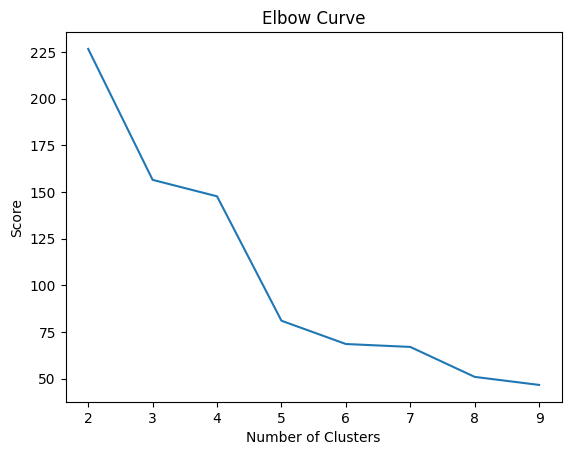

In [45]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

**Building the K-Means Clustering Model**

From the plot above, we can see that there is an inflection point that looks like an elbow at four. Due to this, we will proceed to build the K-Means algorithm with four clusters:

In [46]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

**Making Predictions**

In [47]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+------------------+----------+------------------------------------+----------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardized                                              |prediction|
+--------+---------+------------------+----------+------------------------------------+----------------------------------------------------------+----------+
|63844020|14       |226.14            |16250     |[6.384402E7,14.0,226.14]            |[7934.369236875642,0.7153160251818234,0.5314265800790532] |0         |
|63847020|1        |350.4             |15100     |[6.384702E7,1.0,350.4]              |[7934.742069095647,0.05109400179870167,0.8234362503745478]|0         |
|63819240|14       |205.85999999999999|13065     |[6.381924E7,14.0,205.85999999999999]|[7931.289642738403,0.7153160251818234,0.48376879709504683]|1         |
|63836940|59       |390.78999999999985|12838     |[6

**Cluster Analysis**

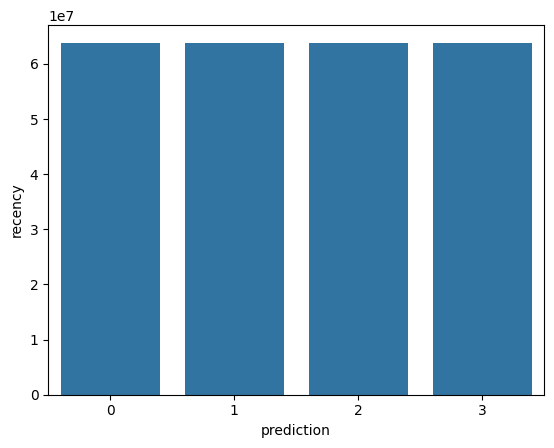

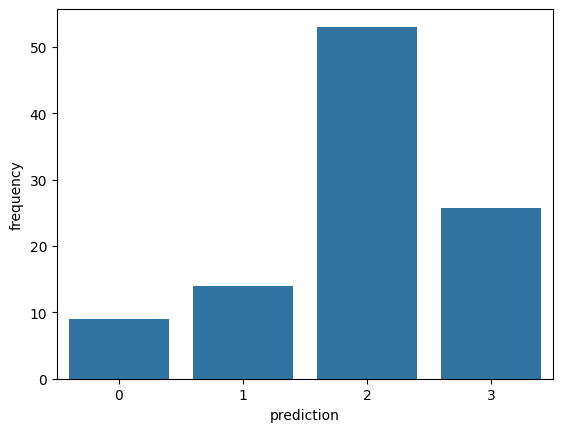

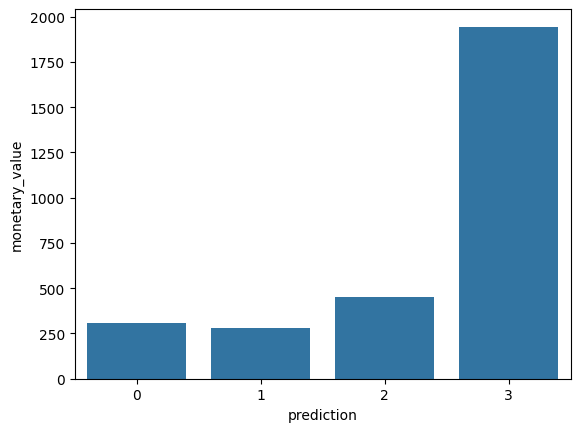

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

**Interpretation**

Here is an overview of characteristics displayed by customers in each cluster:

Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.

Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.

Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.

In [49]:
#stop session

spark.stop()
